# Using different learning schedules
`lightfm` implements two learning schedules: adagrad and adadelta. Neither is clearly superior, and, like other hyperparameter choices, the best learning schedule will differ based on the problem at hand.

This example tries both at the Movielens 100k dataset.

## Preliminaries
Let's first get the data and define the evaluations functions.

In [1]:
import numpy as np
import data

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from lightfm import LightFM

train, test = data.get_movielens_data()

train.data = np.ones_like(train.data)
test.data = np.ones_like(test.data)

from sklearn.metrics import roc_auc_score


def precision_at_k(model, ground_truth, k):
    """
    Measure precision at k for model and ground truth.

    Arguments:
    - lightFM instance model
    - sparse matrix ground_truth (no_users, no_items)
    - int k

    Returns:
    - float precision@k
    """

    ground_truth = ground_truth.tocsr()

    no_users, no_items = ground_truth.shape

    pid_array = np.arange(no_items, dtype=np.int32)

    precisions = []

    for user_id, row in enumerate(ground_truth):
        uid_array = np.empty(no_items, dtype=np.int32)
        uid_array.fill(user_id)
        predictions = model.predict(uid_array, pid_array, num_threads=4)

        top_k = set(np.argsort(-predictions)[:k])
        true_pids = set(row.indices[row.data == 1])

        if true_pids:
            precisions.append(len(top_k & true_pids) / float(k))

    return sum(precisions) / len(precisions)


def full_auc(model, ground_truth):
    """
    Measure AUC for model and ground truth on all items.

    Arguments:
    - lightFM instance model
    - sparse matrix ground_truth (no_users, no_items)

    Returns:
    - float AUC
    """

    ground_truth = ground_truth.tocsr()

    no_users, no_items = ground_truth.shape

    pid_array = np.arange(no_items, dtype=np.int32)

    scores = []

    for user_id, row in enumerate(ground_truth):
        uid_array = np.empty(no_items, dtype=np.int32)
        uid_array.fill(user_id)
        predictions = model.predict(uid_array, pid_array, num_threads=4)

        true_pids = row.indices[row.data == 1]

        grnd = np.zeros(no_items, dtype=np.int32)
        grnd[true_pids] = 1

        if len(true_pids):
            scores.append(roc_auc_score(grnd, predictions))

    return sum(scores) / len(scores)

## Experiment
To evaluate the performance of both learning schedules, let's create two models and run each for a number of epochs, measuring the ROC AUC on the test set at the end of each epoch.

In [2]:
alpha = 1e-3
epochs = 70

adagrad_model = LightFM(no_components=30, loss='warp', learning_schedule='adagrad',
                       user_alpha=alpha, item_alpha=alpha)
adadelta_model = LightFM(no_components=30, loss='warp', learning_schedule='adadelta',
                        user_alpha=alpha, item_alpha=alpha)

adagrad_auc = []

for epoch in range(epochs):
    adagrad_model.fit_partial(train, epochs=1)
    adagrad_auc.append(full_auc(adagrad_model, test))
    
    
adadelta_auc = []

for epoch in range(epochs):
    adadelta_model.fit_partial(train, epochs=1)
    adadelta_auc.append(full_auc(adadelta_model, test))

It looks like the adadelta gets to a better result at the beginning of training. However, as we keep running more epochs adagrad wins out, converging to a better final solution.

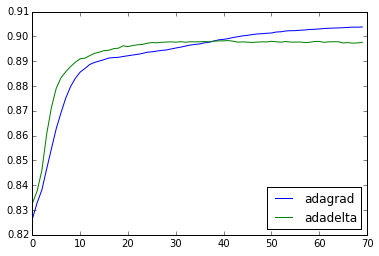

In [3]:
x = np.arange(len(adagrad_auc))
plt.plot(x, np.array(adagrad_auc))
plt.plot(x, np.array(adadelta_auc))
plt.legend(['adagrad', 'adadelta'], loc='lower right')
plt.show()

We can try the same for the k-OS loss.

In [4]:
alpha = 1e-3
epochs = 70

adagrad_model = LightFM(no_components=30, loss='warp-kos', learning_schedule='adagrad',
                       user_alpha=alpha, item_alpha=alpha)
adadelta_model = LightFM(no_components=30, loss='warp-kos', learning_schedule='adadelta',
                        user_alpha=alpha, item_alpha=alpha)

adagrad_auc = []

for epoch in range(epochs):
    adagrad_model.fit_partial(train, epochs=1)
    adagrad_auc.append(full_auc(adagrad_model, test))
    
    
adadelta_auc = []

for epoch in range(epochs):
    adadelta_model.fit_partial(train, epochs=1)
    adadelta_auc.append(full_auc(adadelta_model, test))

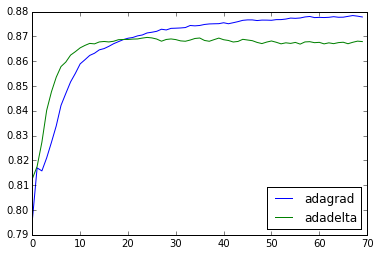

In [5]:
x = np.arange(len(adagrad_auc))
plt.plot(x, np.array(adagrad_auc))
plt.plot(x, np.array(adadelta_auc))
plt.legend(['adagrad', 'adadelta'], loc='lower right')
plt.show()